In [1]:
import numpy as np
#import quaternion
from pyquaternion import Quaternion
import sympy as sym
#start out using mav0
from scipy.spatial.transform import Rotation
import csv
import pandas as pd
import tqdm as tqdm
import matplotlib.pyplot as plt

In [2]:
file_path = 'state_groundtruth_estimate0/data.csv'
df_true_state = pd.read_csv(file_path)
df_true_state.columns = df_true_state.columns.str.strip()

file_path_imu0 = 'imu0/data.csv'
df_imu0 = pd.read_csv(file_path_imu0)
df_imu0.columns = df_imu0.columns.str.strip()

In [3]:
df_cam0 = pd.read_csv('cam0/data.csv')
cam_timestamps = df_cam0['#timestamp [ns]'].values
next_cam_idx = 0

In [4]:
cam_data = [0.0148655429818, -0.999880929698, 0.00414029679422, -0.0216401454975,
         0.999557249008, 0.0149672133247, 0.025715529948, -0.064676986768,
        -0.0257744366974, 0.00375618835797, 0.999660727178, 0.00981073058949,
         0.0, 0.0, 0.0, 1.0]

T_BS_cam = np.array(cam_data).reshape(4, 4)

p_ic = T_BS_cam[0:3, 3].reshape(3, 1)

R_ic = T_BS_cam[0:3, 0:3].T 
q_ic = Quaternion(matrix=R_ic)


In [5]:
# q_t = Quaternion(df_true_state['q_RS_w []'][0], df_true_state['q_RS_x []'][0], df_true_state['q_RS_y []'][0], df_true_state['q_RS_z []'][0])
# omega= np.array([[df_imu0['w_RS_S_x [rad s^-1]'][0]], [df_imu0['w_RS_S_y [rad s^-1]'][0]], [df_imu0['w_RS_S_z [rad s^-1]'][0]]])

In [6]:
def w_x_func(wx, wy, wz):
    return sym.Matrix([[0, -wz, wy],[wz, 0, -wx],[-wy, wx, 0]])

In [7]:
def omega_func(w_vec):
    w = w_vec.flatten() 
    wx, wy, wz = w[0], w[1], w[2]

    Omega = np.array([
        [0, -wx, -wy, -wz],
        [wx, 0, wz, -wy],
        [wy, -wz, 0, wx],
        [wz, wy, -wx, 0]
    ])

    return Omega

In [8]:
def quat_propagation(q_vec, omega, bg):
    q= Quaternion(q_vec)
    w_g= np.array([0, 0, 7.2921e-5]).reshape(-1)
    ng= np.random.normal(loc=0.0, scale=1.9393e-05, size=(3, 1))
    q_elements= q.elements.reshape(-1)
    
   # q= Quaternion(q)

    w_m= omega+q.rotation_matrix@w_g+bg+ng
    omega_hat= w_m-bg-q.rotation_matrix.T@w_g
    qdot= 0.5*omega_func(omega_hat.flatten())@q_elements
    return qdot 

In [9]:
def bg_propagation(nwg):
    nwg= np.random.normal(loc=0.0, scale=1.6968e-04, size=(3, 1))
    bgdot= nwg 
    return bgdot

In [10]:
def ba_propagation(nag): 
    nag= np.random.normal(loc=0.0, scale=2.0000e-3, size=(3, 1))
    badot= nag
    return badot

In [11]:
def vi_propagation(at): 
    vidot= at 
    return vidot

In [12]:
def pi_propagation(vi):
    pidot= vi
    return pidot

In [13]:
def make_XIMU(X, omega, nag, nwg, a_m, w_g= np.array([0, 0, 7.2921e-5])):
    q_vec= X[0:4].reshape(-1)
    q_t_current= Quaternion(q_vec)
    bg = X[4:7].reshape(-1)     
    vi= X[7:10].reshape(-1)     
    ba = X[10:13].reshape(-1)    
    pi= X[13:16].reshape(-1)    

    #q_vec= q_t.elements
    quat= quat_propagation(q_t_current, omega, bg)
    bg= bg_propagation(nwg)    
    ba= ba_propagation(nag)

    a_hat=  a_m.reshape(-1)- ba.reshape(-1) #a_m is found from the imu0 file 
    at= q_t_current.rotation_matrix.T@a_hat-2*w_x_func(w_g[0], w_g[1], w_g[2])@vi- w_x_func(w_g[0], w_g[1], w_g[2])@w_x_func(w_g[0], w_g[1], w_g[2])@pi+np.array([0, 0, 9.8])
    vi= vi_propagation(at)
    pi= pi_propagation(vi)
    X_IMU_numpy = np.hstack([quat.flatten(), bg.flatten(), vi.flatten(), ba.flatten(), pi.flatten()])
    return X_IMU_numpy.reshape(-1, 1), a_hat

In [14]:
def propagate_PII(PII_0, F, G):
    Q_IMU= np.block([
    [1.6968e-04**2 * np.eye(3), np.zeros((3, 3)), np.zeros((3, 3)), np.zeros((3, 3))],
    [np.zeros((3, 3)), 1.9393e-05**2 * np.eye(3), np.zeros((3, 3)), np.zeros((3, 3))],
    [np.zeros((3, 3)), np.zeros((3, 3)), 2.0000e-3**2 * np.eye(3), np.zeros((3, 3))],
    [np.zeros((3, 3)), np.zeros((3, 3)), np.zeros((3, 3)), 3.0000e-3**2 * np.eye(3)]
    ])
    PII_dot= F@PII_0+PII_0@F.T+G@Q_IMU@G.T
    return PII_dot

In [15]:
def propagate_STM(STM, F):
    STMdot=F@STM
    return STMdot

In [16]:
def propagate_covariance(q, P_IC_0_T, P_IC_0_B, P_CC_0, STM_0, P_II_0, curr_X, curr_a, w_m):
    q= Quaternion(q)
    w_g= np.array([0, 0, 7.2921e-5]).reshape(-1)
    ng= np.random.normal(loc=0.0, scale=1.9393e-05, size=(3, 1))
    bg = curr_X[4:7].reshape(-1)
    q_elements= q.elements.reshape(-1)
    #w_m= omega+q.rotation_matrix@w_g+bg+ng
    omega_hat= (w_m-bg-q.rotation_matrix.T@w_g).flatten()
    XIMU, a_hat= curr_X, curr_a
     
    a_hat= a_hat.flatten()
    F=np.block([[np.hstack([-w_x_func(omega_hat[0], omega_hat[1], omega_hat[2]), -np.eye(3), np.zeros((3, 3)), np.zeros((3, 3)), np.zeros((3, 3))])], 
               [np.hstack([np.zeros((3, 3)), np.zeros((3, 3)), np.zeros((3, 3)), np.zeros((3, 3)), np.zeros((3, 3))])], 
               [np.hstack([-q.rotation_matrix.T@w_x_func(a_hat[0], a_hat[1], a_hat[2]), np.zeros((3, 3)), -2*w_x_func(w_g[0], w_g[1], w_g[2]), -q.rotation_matrix.T, -w_x_func(w_g[0], w_g[1], w_g[2]) @ w_x_func(w_g[0], w_g[1], w_g[2])])],
               [np.hstack([np.zeros((3, 3)), np.zeros((3, 3)), np.zeros((3, 3)), np.zeros((3, 3)), np.zeros((3, 3))])],
               [np.hstack([np.zeros((3, 3)), np.zeros((3, 3)), np.eye(3), np.zeros((3, 3)), np.zeros((3, 3))])]]) 


    G= np.block([[np.hstack([-np.eye(3), np.zeros((3, 3)), np.zeros((3, 3)), np.zeros((3, 3))])], 
               [np.hstack([np.zeros((3, 3)), np.eye(3), np.zeros((3, 3)), np.zeros((3, 3))])],
               [np.hstack([np.zeros((3, 3)), np.zeros((3, 3)), -q.rotation_matrix.T, np.zeros((3, 3))])],
               [np.hstack([np.zeros((3, 3)), np.zeros((3, 3)), np.zeros((3, 3)), np.eye(3)])], 
               [np.hstack([np.zeros((3, 3)), np.zeros((3, 3)), np.zeros((3, 3)), np.zeros((3, 3))])]])
    
    P_II_dot= propagate_PII(P_II_0, F, G)
    STM_dot= propagate_STM(STM_0, F)
    P_dot= np.block([[P_II_dot, STM_dot@P_IC_0_T], [P_IC_0_B@STM_dot.T, P_CC_0]])

    return P_dot

In [17]:
def Jacobian(q_bar, N, q_hat, p_c):
    mult= (q_hat.rotation_matrix@p_c).flatten()
    J= np.block([[q_bar.rotation_matrix.T, np.zeros((3, 9)), np.zeros((3, 3)), np.zeros((3, 6*N))], 
                 [w_x_func(mult[0], mult[1], mult[2]), np.zeros((3, 9)), np.eye(3), np.zeros((3, 6*N))]])

    return J 

In [18]:
def augment_state(X_IMU, prop, q_ic, p_ic):
    q_curr= Quaternion(X_IMU[0:4].flatten())
    p_curr= X_IMU[13:16].reshape(-1)

    q_cam = q_curr * q_ic
    p_cam= q_curr.rotation_matrix.T@p_ic+p_curr

    X_new_cam= np.vstack([q_cam.elements.reshape(-1, 1), p_cam.reshape(-1, 1)])
    N = (prop.shape[0] - 15) // 6
    jac= Jacobian(q_IC, N, q_curr, p_ic)

    M = prop.shape[0]
    I_large = np.eye(M)

    augmented_cov= np.vstack([I_large, jac])@prop@np.vstack([I_large, jac]).T

    return X_new_cam, augmented_cov

In [19]:
def rk4_step(make_XIMU, X_0, bg_0, ba_0, omega_0, pi_0, a_m_0, vi_0, q_t_0, nag_0, nwg_0, dt=0.001, h=0.1):
    X = X_0   #this is some placeholder for an original X  
    #print(X_IMU_k, "initial x imu k")
    k1, a_hat1 = make_XIMU(X, omega_0, nag_0, nwg_0, a_m_0)
    X_k2 = X + 0.5 * dt * k1
    k2, a_hat2 = make_XIMU(X_k2,omega_0, nag_0, nwg_0, a_m_0)
    X_k3 = X + 0.5 * dt * k2
    k3, a_hat3 = make_XIMU(X_k3, omega_0, nag_0, nwg_0, a_m_0)
    X_k4 = X + dt * k3
    k4, a_hat4 = make_XIMU(X_k4, omega_0, nag_0, nwg_0, a_m_0)
    X_IMU_k_plus_1 = X + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
    q_new_elements = X_IMU_k_plus_1[0:4]
    q_new_normalized = Quaternion(q_new_elements).normalised.elements
    X_IMU_k_plus_1[0:4] = q_new_normalized.reshape(4, 1)
    a_hat_plus_1 = a_m_0 + (dt / 6.0) * (a_hat1 + 2*a_hat2 + 2*a_hat3 + a_hat4)
    
    return X_IMU_k_plus_1, a_hat_plus_1 

In [20]:
def inverse_depth_residual(alpha, beta, rho, feature_track, cam_states, anchor):
    residuals=[]
    X_anchor = cam_states[anchor_idx]
    q_anchor = Quaternion(X_anchor[0:4].flatten())
    p_anchor = X_anchor[4:7].reshape(-1, 1)
    vec_anchor=np.array([alpha, beta, 1]).reshape(3, 1)

    for i in feature_track:
        cam_idx, u_meas, v_meas= i

        if cam_idx==anchor:
            continue

        X_curr= cam_states[cam_idx]
        q_curr= Quaternion(X_curr[0:4].flatten())
        p_curr=X_curr[4:7].reshape(-1, 1)

        p_F= q_curr.rotation.T@q_anchor.rotation@vec_anchor+rho*(q_curr.rotation_matrix.T@(p_anchor-p_curr))

        line1, line2, line3= p_F[0], p_F[1], p_F[2]

        if np.abs(line3)>0.0001:
            continue

        u_hat = line1 / line3 
        v_hat = line2 / line3 

        # Calculate Error (Measurement - Prediction)
        residuals.append(u_meas - u_hat)
        residuals.append(v_meas - v_hat)

    return np.array(residuals) 

In [21]:
def triangulate_feature(feature_track, cam_states):
    anchor_idx, u_init, v_init= feature_track[0]

    result = least_squares(
        inverse_depth_residual, 
        x0, 
        method='lm',
        args= (feature_track, cam_states, anchor_idx), 
        verbose=0
    )
    X_anchor = cam_states[anchor_idx]
    q_anchor = Quaternion(X_anchor[0:4].flatten())
    p_anchor = X_anchor[4:7].reshape(-1, 1)

    vec_anchor=np.array([alpha, beta, 1]).reshape(3, 1)

    pgf= rho**-1*q_anchor.rotation.T@vec_anchor+p_anchor

    return pgf
    

In [22]:
def residuals_and_jacobians(feature_track, cam_states, pgf, num_cameras):
    hx_list=[]
    hf_list=[]
    r_list=[]

    for i in feature_track:
        cam_idx, u_meas, v_meas= i
        X_curr= cam_states[cam_idx]
        q_curr= Quaternion(X_curr[0:4].flatten())
        p_curr=X_curr[4:7].reshape(-1, 1)

        pcf= q_curr.rotation.T@(pgf-p+curr)
        x, y, z= pcf.flatten()

        zhat= np.array([X/Z, Y/Z]).reshape(2, 1)
        zmeas= np.array([u_meas, v_meas]).reshape(2, 1)

        residual= zmeas-zhat

        J_proj = (1.0 / Z) * np.array([
        [1, 0, -X/Z],
        [0, 1, -Y/Z]
        ])
        H_f_i = J_proj @ q_curr.rotation_matrix.T
        H_theta_i = J_proj @ w_x_func(X, Y, Z)

        H_pos_i = -H_f_i
        dim_state = 15 + 6 * N_cameras
        H_x_i = np.zeros((2, dim_state))
        
        col_idx = 15 + (6 * cam_idx)
        
        H_x_i[:, col_idx : col_idx+3]   = H_theta_i
        H_x_i[:, col_idx+3 : col_idx+6] = H_pos_i
        
        hx_list.append(H_x_i)
        hf_list.append(H_f_i)
        r_list.append(residual)

    return np.vstack(H_x_list), np.vstack(H_f_list), np.vstack(r_list)

In [23]:
def nullspace_projection(Hx, Hf, r):
    Q, _= np.linalg.qr(Hf, mode="complete")
    Q_null= Q[:, 3:]
    ro= Q_null.T@r
    Ho= Q_null.T@H_x

    return Ho, ro 

In [24]:
def state_correction(X_curr, P, Hx, ro, cam_states):
    Q, R= np.linalg.qr(Hx, mode="reduced")
    Th= R
    Q1= Q
    rn= Q1.T @ ro
    
    sigma= 1.0
    R_n= sigma**2 * np.eye(Q1.shape[0])
    
    S= Th@ P @ Th.T + R_n
    K= P @ Th.T @ np.linalg.inv(S)

    del_X=K @ rn

    Identity = np.eye(P.shape[0])
    P_new = (Identity - K @ Th) @ P 
    
    dtheta = del_X[0:3].flatten()
    angle = np.linalg.norm(dtheta)
    dq = Quaternion(axis=dtheta/angle, angle=angle)

    q_old =Quaternion(X_curr[0:4].flatten())
    q_new =q_old * dq

    X_imu_vecs = X_curr[4:16] + del_X[3:15].reshape(-1, 1)
    X_imu_new = np.vstack([q_new.elements.reshape(-1, 1), X_imu_vecs])

    N_cams= (del_X.shape[0] - 15) // 6
    cam_states_new = []

    if N_cams > 0:
        for i in range(N_cams):
            x_idx= 16 + 7*i
            d_idx= 15 + 6*i

            d_theta_c= del_X[d_idx : d_idx+3].flatten()
            angle_c= np.linalg.norm(d_theta_c)
            dq_c = Quaternion(axis=d_theta_c/angle_c, angle=angle_c)
            q_c_old= Quaternion(X_curr[x_idx : x_idx+4].flatten())
            q_c_new= q_c_old * dq_c
            
            p_c_new= X_curr[x_idx+4 : x_idx+7] + del_X[d_idx+3 : d_idx+6].reshape(-1, 1)
            cam_state_i = np.vstack([q_c_new.elements.reshape(-1, 1), p_c_new])
            cam_states_new.append(cam_state_i)
            
        X_final = np.vstack([X_imu_new] + cam_states_new)
    else:
        X_final = X_imu_new

    return X_final, P_new, cam_states_new

In [25]:
def prune_state(P_curr, cam_states, N_max=20):
    N = len(cam_states)
    if N <= N_max:
        return P_curr, cam_states
    
    num_remove = int(N_max / 3)
    stride = max(1, int((N - 1) / num_remove))
    
    indices_to_remove = []
    for i in range(num_remove):
        idx = 1 + (i * stride)
        if idx < N:
            indices_to_remove.append(idx)
            
  
    p_indices_to_delete = []
    for cam_idx in indices_to_remove:
        start = 15 + (6 * cam_idx)
        p_indices_to_delete.extend(range(start, start + 6))
        
    P_curr = np.delete(P_curr, p_indices_to_delete, axis=0) # Delete Rows
    P_curr = np.delete(P_curr, p_indices_to_delete, axis=1) # Delete Cols
    remove_set = set(indices_to_remove)
    cam_states = [c for i, c in enumerate(cam_states) if i not in remove_set]
    
    return P_curr, cam_states

In [30]:
#initial conditions/constants: 
nag_0= np.array([0.5, 0.5, 0.5])
nwg_0= np.array([0.5,0.5 ,0.5])
bg_0= np.array([0, 0, 0])
ba_0= np.array([0, 0 ,0])
omega_0= np.array([[df_imu0['w_RS_S_x [rad s^-1]'][0]], [df_imu0['w_RS_S_y [rad s^-1]'][0]], [df_imu0['w_RS_S_z [rad s^-1]'][0]]])
q_t_0= Quaternion(df_true_state['q_RS_w []'][0], df_true_state['q_RS_x []'][0], df_true_state['q_RS_y []'][0], df_true_state['q_RS_z []'][0])
pi_0= np.array([df_true_state['p_RS_R_x [m]'][0], df_true_state['p_RS_R_y [m]'][0], df_true_state['p_RS_R_z [m]'][0]])
vi_0= np.array([df_true_state['v_RS_R_x [m s^-1]'][0], df_true_state['v_RS_R_y [m s^-1]'][0], df_true_state['v_RS_R_z [m s^-1]'][0]])
a_m_0= np.array([df_imu0['a_RS_S_x [m s^-2]'][0], df_imu0['a_RS_S_y [m s^-2]'][0], df_imu0['a_RS_S_z [m s^-2]'][0]])
X_0= np.hstack([q_t_0.elements, bg_0.flatten(), vi_0.flatten(), ba_0.flatten(), pi_0.flatten()]).flatten().reshape(-1, 1)

P_dtheta_mag = 1e-8
P_v_mag = 1e-8
P_p_mag = 1e-8
P_bg_mag = 1e-4
P_ba_mag = 1e-4
P_dtheta = (P_dtheta_mag**2) * np.eye(3) 
P_bg = (P_bg_mag**2) * np.eye(3)     
P_v  = (P_v_mag**2) * np.eye(3)     
P_ba = (P_ba_mag**2) * np.eye(3)   
P_p  = (P_p_mag**2) * np.eye(3)       

P_II_0 = np.block([
    [P_dtheta, np.zeros((3, 12))],
    [np.zeros((3, 3)), P_bg, np.zeros((3, 9))],
    [np.zeros((3, 6)), P_v, np.zeros((3, 6))],
    [np.zeros((3, 9)), P_ba, np.zeros((3, 3))],
    [np.zeros((3, 12)), P_p]
])
q_bar_0= Quaternion(df_true_state['q_RS_w []'][0], df_true_state['q_RS_x []'][0], df_true_state['q_RS_y []'][0], df_true_state['q_RS_z []'][0])
STM_0= np.eye(15)
p_c= np.array([df_true_state['p_RS_R_x [m]'][0], df_true_state['p_RS_R_y [m]'][0], df_true_state['p_RS_R_z [m]'][0]])
P_IC_0_T= P_II_0@Jacobian(q_bar_0, 2, q_t_0, p_c)[:, 0:15].T #np.block([np.eye(6*N+15))],[])
P_IC_0_B= P_IC_0_T.T
N=1
P_CC_0= np.zeros((6*N, 6*N))


In [34]:
X_init, a_init= (rk4_step(make_XIMU, X_0, bg_0, ba_0, omega_0, pi_0, a_m_0, vi_0, q_t_0, nag_0, nwg_0, dt=0.001, h=0.1))
X=X_init
a=a_init
prop_init= propagate_covariance(q_bar_0, P_IC_0_T, P_IC_0_B, P_CC_0, STM_0, P_II_0, X_init, a_init, omega_0)
prop=prop_init
camera_states=[]
est_history=[]
est_vel=[]
gt_history=[]

In [35]:
for i in tqdm.tqdm (range (0, 200)):
    #q_vec= X[0:4].reshape(-1)
    #q_t_current= Quaternion(q_vec)
    w_x = df_imu0['w_RS_S_x [rad s^-1]'].iloc[i]
    w_y = df_imu0['w_RS_S_y [rad s^-1]'].iloc[i]
    w_z = df_imu0['w_RS_S_z [rad s^-1]'].iloc[i]
    omega_k = np.array([w_x, w_y, w_z]).reshape(-1, 1)

    a_x = df_imu0['a_RS_S_x [m s^-2]'].iloc[i]
    a_y = df_imu0['a_RS_S_y [m s^-2]'].iloc[i]
    a_z = df_imu0['a_RS_S_z [m s^-2]'].iloc[i]
    a_m_k = np.array([a_x, a_y, a_z]).reshape(-1, 1)

    
    X_curr, a_curr= rk4_step(make_XIMU, X, X[4:7].reshape(-1), X[10:13].reshape(-1), omega_k, X[13:16].reshape(-1), a_m_k, X[7:10].reshape(-1), X[0:4].reshape(-1), np.random.normal(loc=0.0, scale=2.0000e-3, size=(3, 1)), np.random.normal(loc=0.0, scale=1.6968e-04, size=(3, 1)), dt=0.001, h=0.1)  
    X=X_curr
    a=a_curr

    P_II_k = prop[0:15, 0:15]
    P_IC_T_k = prop[0:15, 15:]
    P_IC_B_k = prop[15:, 0:15]
    P_CC_k = prop[15:, 15:]
    STM_k = np.eye(15)
    q_curr_vec = X_curr[0:4].reshape(-1)
    
    prop_curr= propagate_covariance(q_curr_vec, P_IC_T_k, P_IC_B_k, P_CC_k, STM_k, P_II_k, X, a, omega_k)
    prop=prop_curr

    curr_time = df_imu0['#timestamp [ns]'].iloc[i]
    if next_cam_idx < len(cam_timestamps) and curr_time >= cam_timestamps[next_cam_idx]:
        next_cam_idx = next_cam_idx+1
        X_cam, prop = augment_state(X, prop, q_ic, p_ic)
        camera_states.append(X_cam)
        if len(feature_tracks) > 0:
            H_all = []
            r_all = []
            N_cams = len(camera_states)
    
            for track in feature_tracks:
                pgf = triangulate_feature(track, cam_states_history)
            
                Hx, Hf, r = residuals_and_jacobians(track, cam_states_history, pgf, N_cams)
                Ho, ro= project_nullspace(Hx, Hf, r)
                
                H_all.append(Ho)
                r_all.append(ro)
                
            H_final = np.vstack(H_all)
            r_final = np.vstack(r_all)
            X, prop, cam_states = state_correction(X, prop, H_final, r_final, cam_states)



    prop, camera_states= prune_state(prop, camera_states, N_max=20)
        
    next_cam_idx= next_cam_idx+1

    est_history.append(X[13:16].flatten())
    est_vel.append(X[7:10].flatten())
    
    gt_p = np.array([
        df_true_state['p_RS_R_x [m]'].iloc[i],
        df_true_state['p_RS_R_y [m]'].iloc[i],
        df_true_state['p_RS_R_z [m]'].iloc[i]
    ])
    gt_history.append(gt_p)

    

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [01:08<00:00,  2.93it/s]


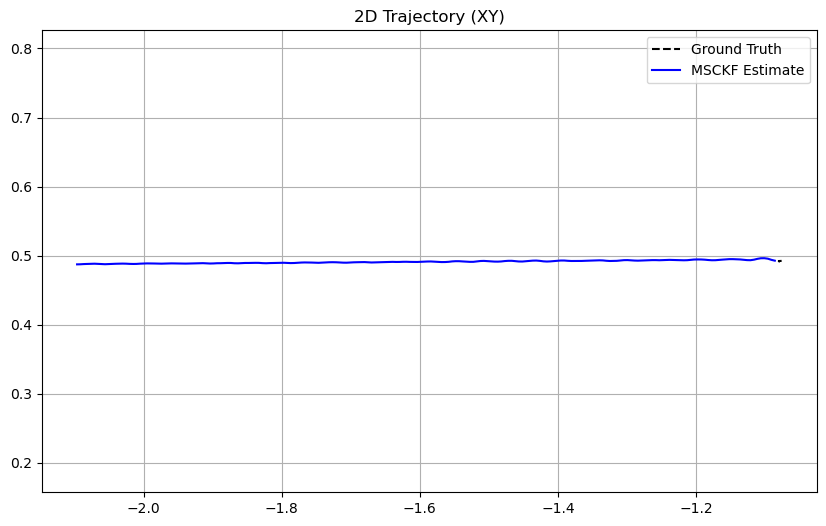

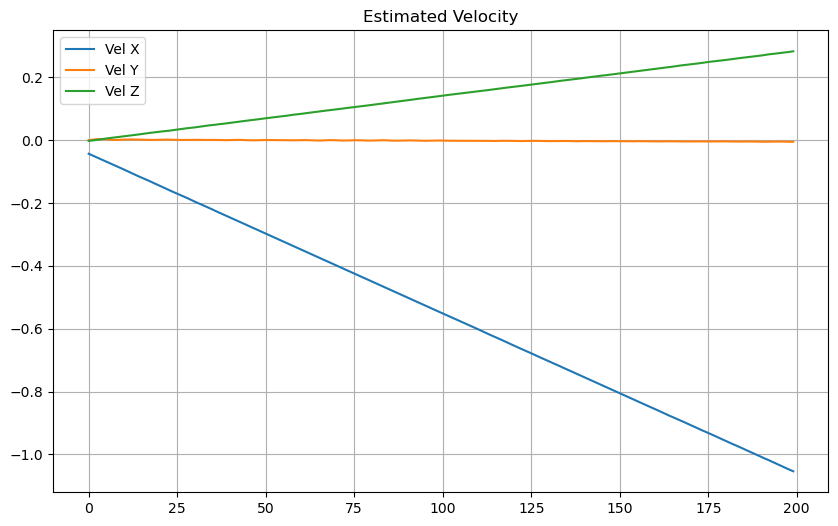

In [39]:
import matplotlib.pyplot as plt
# Plot
est_arr = np.array(est_history)
gt_arr = np.array(gt_history)
vel_arr = np.array(est_vel)

plt.figure(figsize=(10, 6))
plt.plot(gt_arr[:,0], gt_arr[:,1], 'k--', label='Ground Truth')
plt.plot(est_arr[:,0], est_arr[:,1], 'b-', label='MSCKF Estimate')
plt.title('2D Trajectory (XY)')
plt.legend()
plt.axis('equal')
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(vel_arr[:,0], label='Vel X')
plt.plot(vel_arr[:,1], label='Vel Y')
plt.plot(vel_arr[:,2], label='Vel Z')
plt.title('Estimated Velocity')
plt.legend()
plt.grid()
plt.show()